In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/NLP2

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/NLP2


In [4]:
import pickle

# Load the saved embeddings
print("\n**Loading saved embeddings...**")
with open('tweet_embeddings.pkl', 'rb') as f:
    loaded_embeddings = pickle.load(f)

# Verify the loaded data
print("\n**Verification of loaded data:**")
for split in ['train', 'val', 'test']:
    emb_shape = loaded_embeddings[split]['embeddings'].shape
    num_labels = len(loaded_embeddings[split]['labels'])
    num_tweets = len(loaded_embeddings[split]['tweets'])

    print(f"\n{split.upper()} set:")
    print(f"  - Embeddings shape: {emb_shape}")
    print(f"  - Number of labels: {num_labels}")
    print(f"  - Number of tweets: {num_tweets}")
    print(f"  - Embedding dimension: {emb_shape[1]}")

# Example: Access specific embeddings
print("\n**Example usage of loaded embeddings:**")
train_embeddings = loaded_embeddings['train']['embeddings']
train_labels = loaded_embeddings['train']['labels']
print(f"First tweet embedding shape: {train_embeddings[0].shape}")
print(f"First tweet label: {train_labels[0]}")


**Loading saved embeddings...**

**Verification of loaded data:**

TRAIN set:
  - Embeddings shape: (12146, 384)
  - Number of labels: 12146
  - Number of tweets: 12146
  - Embedding dimension: 384

VAL set:
  - Embeddings shape: (2603, 384)
  - Number of labels: 2603
  - Number of tweets: 2603
  - Embedding dimension: 384

TEST set:
  - Embeddings shape: (2603, 384)
  - Number of labels: 2603
  - Number of tweets: 2603
  - Embedding dimension: 384

**Example usage of loaded embeddings:**
First tweet embedding shape: (384,)
First tweet label: negative


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Prepare the data
print("**Preparing data...**")

# Extract data from loaded embeddings
X_train = loaded_embeddings['train']['embeddings']
y_train = loaded_embeddings['train']['labels']

X_val = loaded_embeddings['val']['embeddings']
y_val = loaded_embeddings['val']['labels']

X_test = loaded_embeddings['test']['embeddings']
y_test = loaded_embeddings['test']['labels']

# Convert labels to numerical format
label_encoder = LabelEncoder()
label_encoder.fit(['negative', 'neutral', 'positive'])  # Ensure consistent ordering

y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to categorical (one-hot encoding)
num_classes = 3
y_train_categorical = keras.utils.to_categorical(y_train_encoded, num_classes)
y_val_categorical = keras.utils.to_categorical(y_val_encoded, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test_encoded, num_classes)

print(f"\nClass mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Create a simple neural network model
print("\n**Building model...**")

model = keras.Sequential([
    layers.Input(shape=(384,)),  # Input layer for 384-dimensional embeddings
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

# Set up early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("\n**Training model...**")
history = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

**Preparing data...**

Class mapping: {np.str_('negative'): np.int64(0), np.str_('neutral'): np.int64(1), np.str_('positive'): np.int64(2)}

**Building model...**


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,715 (233.26 KB)

 Trainable params: 59,715 (233.26 KB)

 Non-trainable params: 0 (0.00 B)


**Training model...**
Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5477 - loss: 0.9050 - val_accuracy: 0.7345 - val_loss: 0.6266
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7413 - loss: 0.6247 - val_accuracy: 0.7453 - val_loss: 0.6023
Epoch 3/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7561 - loss: 0.5816 - val_accuracy: 0.7599 - val_loss: 0.5682
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7715 - loss: 0.5539 - val_accuracy: 0.7672 - val_loss: 0.5551
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7914 - loss: 0.5145 - val_accuracy: 0.7668 - val_loss: 0.5556
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8035 - loss: 0.4959 - val_accuracy: 0.7580 - val_loss: 0.5592
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8049 - loss: 0.4917 - val_accuracy: 0.7618 - val_loss: 0.5553
Epoch 8/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8158 

In [5]:
# 1. Save as .h5 format (Keras native format)
model.save('tweet_sentiment_model.h5')
print("Model saved as 'tweet_sentiment_model.h5'")

NameError: name 'model' is not defined

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

loaded_model = keras.models.load_model('tweet_sentiment_model.h5')


**Evaluating model on test set...**
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Test Accuracy: 0.7580
Test Loss: 0.5703

**Classification Report:**
              precision    recall  f1-score   support

    negative       0.74      0.89      0.81       868
     neutral       0.73      0.65      0.69       867
    positive       0.80      0.74      0.77       868

    accuracy                           0.76      2603
   macro avg       0.76      0.76      0.76      2603
weighted avg       0.76      0.76      0.76      2603

Confusion matrix, without normalization


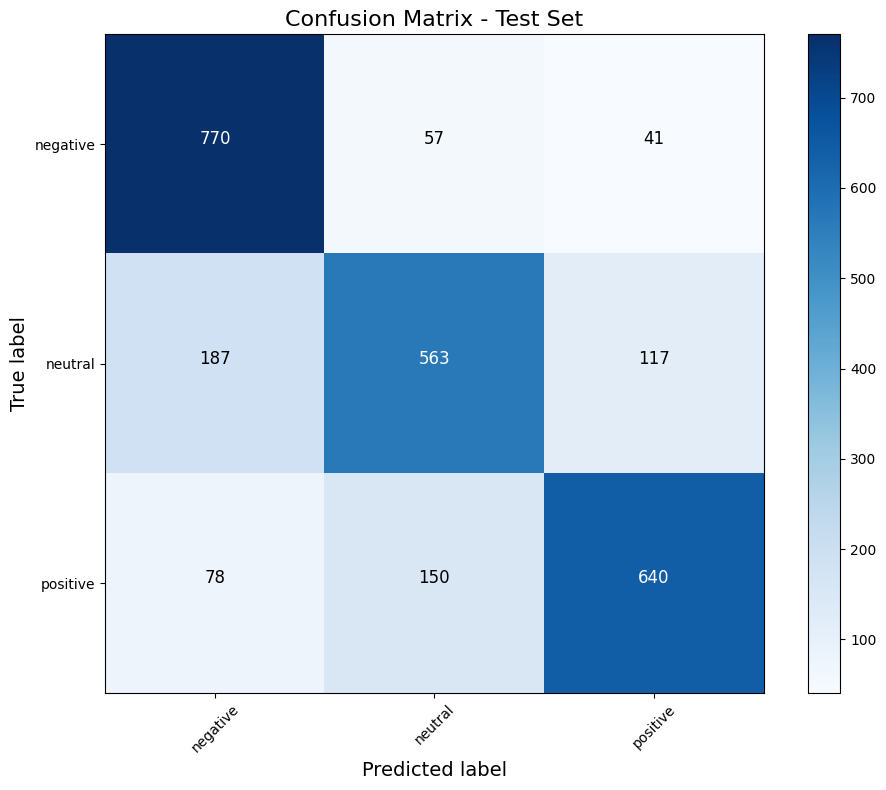

Normalized confusion matrix


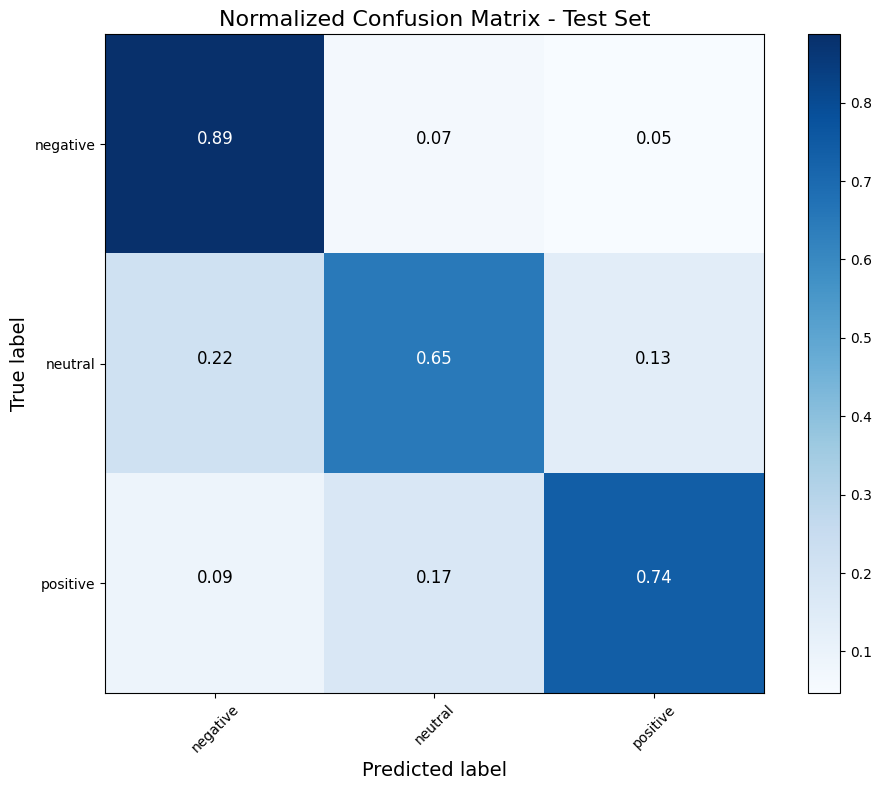


**Per-class Accuracy:**
negative: 0.8871 (770/868)
neutral: 0.6494 (563/867)
positive: 0.7373 (640/868)

**Overall Metrics:**
Accuracy: 0.7580
Precision (macro): 0.7590
Recall (macro): 0.7579
F1-Score (macro): 0.7551


In [ ]:
# Evaluate the model on test set
print("\n**Evaluating model on test set...**")

# Get predictions
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Calculate test accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Convert back to original labels for better interpretation
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_test_labels = label_encoder.inverse_transform(y_test_classes)

# Print classification report
print("\n**Classification Report:**")
print(classification_report(y_test_labels, y_pred_labels))

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools

# Create confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=['negative', 'neutral', 'positive'])

# Custom function for better visualization
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 8))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Format for displaying values
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot regular confusion matrix
plot_confusion_matrix(cm, classes=['negative', 'neutral', 'positive'],
                     normalize=False, title='Confusion Matrix - Test Set')

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=['negative', 'neutral', 'positive'],
                     normalize=True, title='Normalized Confusion Matrix - Test Set')

# Additional metrics
print("\n**Per-class Accuracy:**")
for i, label in enumerate(['negative', 'neutral', 'positive']):
    class_correct = np.sum((y_test_labels == label) & (y_pred_labels == label))
    class_total = np.sum(y_test_labels == label)
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"{label}: {class_accuracy:.4f} ({class_correct}/{class_total})")

# Calculate and display overall metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n**Overall Metrics:**")
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels):.4f}")
print(f"Precision (macro): {precision_score(y_test_labels, y_pred_labels, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test_labels, y_pred_labels, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_test_labels, y_pred_labels, average='macro'):.4f}")


#Single Prediction

In [9]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [10]:
# Tek bir cümle için tahmin fonksiyonu
def predict_sentiment(text):
    embedding = embedding_model.encode([text], convert_to_tensor=True)

    prediction = loaded_model.predict(embedding)
    predicted_class = np.argmax(prediction[0])

    class_names = ['negative', 'neutral', 'positive']

    return class_names[predicted_class], prediction[0]


text = "What a stunning goal by Ronaldo!"
sentiment, probabilities = predict_sentiment(text)

print(f"Metin: {text}")
print(f"Tahmin: {sentiment}")
print(f"Olasılıklar - Negative: {probabilities[0]:.3f}, Neutral: {probabilities[1]:.3f}, Positive: {probabilities[2]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Metin: What a stunning goal by Ronaldo!
Tahmin: positive
Olasılıklar - Negative: 0.000, Neutral: 0.001, Positive: 0.999
